## Global historical Wine Trade/Consumption
(Megafile_of_Global_Wine_Data_1835_to_2016)

In [829]:
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import requests
import json
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot
import matplotlib.mlab as mlab
from statistics import mean
from scipy.stats import sem
from scipy.stats import norm

from api_keys import (owmkey,gkey)

# Analyzing global historial wine trade (Working on Giant MS-Excel File)
This function reads the name of worksheet within the gian Excel Worksheet (string) 
together with the number of  bottom redundant rows (brr) and top header rows (thr) (two integers)
and return the lcean dataframe with the year as index.
Note: the thr and brr arguments are optional but the sheet_name is required.

In [306]:
# removing the unnecessary row from top or bottom
# relocating the columns and removing unnecessary ones
# reset indexing
def giant_worksheet(sheet_giant,brr=0, thr=0):
    
    df = pd.read_excel('../data/rawdata/Megafile_of_global_wine_data_1835_to_2016_1217.xlsx', 
                         sheet_name=sheet_giant, header=1, index_col=None)
    df.index.rename('year',inplace=True)
    df=df.reset_index()
    df.fillna(-1,inplace=True) #fills empty cells with -1
    
    #relocating the Norway column if exist
    try:
        nor = df['Norway']
        df.drop(labels=['Norway'], axis=1,inplace = True)
        df.insert(6, 'Norway', nor)
    except:
        print('NO Norway column found in worksheet:', sheet_giant)

    #df.drop(labels=['nan'], axis=1,inplace = True)
    df=df.rename(columns={'Bel-Lux':'Belgium'}) #chnage the name of Be-Lux to Belgium
    df.drop(labels=['Coeff. of variation'], axis=1,inplace = True) #remove the coeff of var column.
    df.drop(labels=['Other'], axis=1,inplace = True) #remove the Other column
    df.drop(labels=['Other Asia Pacific'], axis=1,inplace = True) #remove the Other column
    #df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    row_to_drop=list(range(thr))
    df=df.drop(df.index[row_to_drop])
    if brr !=0:
        df=df[:-brr]
    df.set_index('year',inplace=True)
    return df


## Data wrangling (from the giant Excel workbook)

In [307]:
#reading worksheets, wrangling and saving all sheets to a new workbook

outputpath="..\data\cleandata\Wine_History.xlsx"
writer = pd.ExcelWriter(outputpath, engine='xlsxwriter')
#Now reading Wine consumption volume(dfwcv) (KL) (ws #34)

sheetname='T34 Wine consumption vol'
dfwcv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwcv.to_excel(writer, sheet_name=sheetname)

sheetname='T6 Wine production'
#Now reading Wine production volume(dfwpv) (KL) (ws #6)
dfwpv=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwpv.to_excel(writer, sheet_name=sheetname)

sheetname='T96 Wine cons intensity index'
#Reading global wine consumption intensity index (dfwcii) (ws #96)
dfwcii=giant_worksheet(sheet_giant=sheetname, brr=15,thr=126)
dfwcii.to_excel(writer, sheet_name=sheetname)

sheetname='T38 Wine consumption per capita'
#Reading global wine consumption per capita (dfwcpc) (litres) (ws #38)
dfwcpc=giant_worksheet(sheet_giant=sheetname,thr=30)
dfwcpc.to_excel(writer, sheet_name=sheetname)

sheetname='T8 Wine prodn per capita'
#Reading global wine production per capita (dfwppc) (litres) (ws #8)
dfwppc=giant_worksheet(sheet_giant=sheetname,thr=30,brr=3)
dfwppc.to_excel(writer, sheet_name=sheetname)

sheetname='T58 Population'
#Reading global population (dfgp) (*1000) (ws #58)
dfgp=giant_worksheet(sheet_giant=sheetname,thr=30)
dfgp.to_excel(writer, sheet_name=sheetname)

writer.save()

NO Norway column found in worksheet: T6 Wine production
NO Norway column found in worksheet: T8 Wine prodn per capita


## Plotting global wine trade plots based on the generated dataframes

In [308]:
country_name =['United States', 'Canada', 'Italy', 'France', 'Spain', 'Brazil', 'Australia', 
               'Portugal','United Kingdom','Norway','World']

### This function summerizes the plotting (Plotly) requests for every dataframe from the giant file 

In [309]:
# It takes left y-axis and (if exists) right y-axis paramters and name of the dataframe to extract the data from. 
# Input:
#      ldf: dataframe required for primary (left) y-axis (required)
#      rdf: dataframe required for secondary (right) y-axis 
#      llg: inquiry list for primary y-axis (required)
#      rlg: inquiry list for secondary y-axis
#      nyax: 1: only primary y-axis, 2: prmiary and secondary y-axis

# Putput:
#      figure object (fig) that can be plotted by pltly

def plot_scatter(_title, ldf, llg, rdf=[], rlg=[], nyax=1):
    data = []
    tracex = []
    shps = []

    # we define two y=axis based on primary y-axis group (lyg) and, if exists, secondary y-axis group (ryg)
    for x in llg:
        trace =  go.Scatter(
              x=ldf.index,
              y=ldf[x],
              name=x
        )
        data.append(trace)
    
    for x in rlg:
        trace= go.Scatter(
              x=rdf.index,
              y=rdf[x],
              name=x,
              yaxis='y2'
        )
        data.append(trace)
    
    layout = {
        'autosize':False,
        'height': 800,
        'title' : _title,
        'xaxis' : {'title' : 'Year'},
        'yaxis' : {'title' : 'XXX',
                   'range':[0,max(ldf[x].max() for x in llg)*1.05],
                   'automargin':True},
        'showlegend': True,
        #'shapes': shps
    }
    fig = go.Figure(data=data, layout=layout)
    if (nyax==2):
        fig.layout.update({'yaxis2' : {'title' : 'World Population',
                                       'range':[0,max(rdf[x].max() for x in rlg)*1.05],
                                       'automargin':True,
                                       'side': 'right',
                                       'overlaying': 'y'
                                      }
                          })
        
    fig.layout.update({'height':800})
    plot(fig, filename = _title+'.html', auto_open=False)
    
    return fig

### Plotting scatters of the generated dataframes from the giant file

In [310]:
#dfwcii scatter plot
init_notebook_mode(connected=True)
iplot(plot_scatter('Global_wine_consumption_intensity_index',dfwcii,country_name))

In [311]:
#dfwcv scatter plot
init_notebook_mode(connected=True)
iplot(plot_scatter('Global_wine_consumption_volume',dfwcv,country_name))

In [312]:
# Scatter plot: World wine consumption/production together with world population
init_notebook_mode(connected=True)
rg=['World'] #right y-axis list

#option 1: per cpaita results
#lgpc=['World_prod_per_capita','World_consump_per_capita'] #left y-axis list
#gcppc=pd.DataFrame({'World_prod_per_capita':dfwppc['World'], 'World_consump_per_capita': dfwcpc['World']}) #left y-axis dtaframe
#iplot(plot_scatter('Global Production_Consumption per Capita',gcppc,lgpc,rdf=dfgp,rlg=rg,nyax=2))


option 2: volumetric results
lg=['World_prod','World_consump']
gcpv=pd.DataFrame({'World_prod':dfwpv['World'], 'World_consump': dfwcv['World']}) #left y-axis dataframe
iplot(plot_scatter('Global Volumetric Production Consumption (KL)',gcpv,lg,rdf=dfgp,rlg=rg,nyax=2))

SyntaxError: invalid syntax (<ipython-input-312-429ab48d46ee>, line 11)

# Analyzing global historical wine price,rating,variety, (Working on 130k MS-Excel File)

## Data Wrangling (from the 130K Excel workbook)

### 1) Import data from 130k Excel workbook

### 2) Cleaning up the data (e.g. remow null values, tester twitter column),  and 

### 3) Export the data back to another csv file

### Note: It reduced the number of studied wines from 129970 to 121000

In [313]:

file_one = "../data/rawdata/winemag-data-130k-v2.csv"
df = pd.read_csv(file_one,index_col=0)
#cleaning data: delete the taster_tweeter address column
df.drop(columns=['taster_twitter_handle'])
#drop any null values
df = df.dropna(subset=['country','points','price'])
df.sort_values(by=['price'],ascending=False)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
80290,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet
15840,France,The wine is a velvet glove in an iron fist. Th...,NaN,96,2500.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus
98380,France,"A superb wine from a great year, this is power...",NaN,96,2500.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair
120391,US,The nose on this single-vineyard wine from a s...,Roger Rose Vineyard,91,2013.0,California,Arroyo Seco,Central Coast,Matt Kettmann,@mattkettmann,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair
113564,France,"A wonderfully complete wine, with all the elem...",NaN,96,2000.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair
65352,France,This extravagantly perfumed wine has great jui...,NaN,97,2000.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus
1558,France,"A massive wine for Margaux, packed with tannin...",NaN,98,1900.0,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux
111755,France,This is the finest Cheval Blanc for many years...,NaN,100,1500.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Cheval Blanc 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Cheval Blanc
111753,France,"Almost black in color, this stunning wine is g...",NaN,100,1500.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild
1575,France,"The purest Cabernet Sauvignon fruit, with dark...",NaN,96,1300.0,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild


## Wine categories:
1) Bold Red: Malbec, Syrah, Shiraz, Mourvedre, Pinotage, Petite Sirah, Touriga Nacional, Cabernet Sauvignon, Bordeaux Blend, Meritage

2) Medium Red: Meriot, Sangiovese, Zinfandel, Cabernet Franc, Tempranillo, Nebbiolo, Barbera, Cotes du Rhone Blend

3) Light Red: Pinot Noir, Grenache, Gamay, St. Laurent, Carignan, Counoise

4) Rich White: Chardonnay, Semillon, Viognier, Marsanne, Roussanne

5) Light White: Sauvignon Blanc, Albarino, Pitot Blanc, Vermentino, Melon de Bourgogne, Gargenega, Trebbiano, Pinot Gris, Pinot Grigio, Veltliner

6) Rose: Provencal Rose, White Zinfandel, Loire Valley Rose, Pinot Noir Rose, Syrah Rose, Garnache Rosado, Bandol Rose, Tempranilio Rose, Saignee Method Rose

7) Sweet White: Moscato, Riesling, Chenin Blanc, Gewurztraminer, Late Harvest Whites, Alascian Pinot Gris

8) Sparkling: Champagne, Prosecco, Cremant, Cava, Metodo Classico, Sparkling Wine, Sparkling Rose

9) Dessert: Port, Sherry, Maderia, Vin Santo, Muscat, PX, Pedro Ximenez

In [314]:
Wine_types={'Bold Red': ['Malbec', 'Syrah','Red Blend','Shiraz', 'Mourvedre', 'Merlot','Bordeaux-style Red Blend', 'Pinotage', 'Petite Sirah', 'Touriga Nacional', 'Cabernet Sauvignon', 'Portuguese Red', 'Meritage'],
            'Medium Red': ['Meriot', 'Sangiovese', 'Rhône-style Red Blend','Zinfandel','Cabernet Franc', 'Tempranillo', 'Nebbiolo', 'Barbera', 'Cotes du Rhone Blend'],
            'Light Red':['Pinot Noir', 'Grenache', 'Gamay', 'St. Laurent', 'Carignan', 'Counoise'],
            'Rich White': ['Chardonnay', 'Semillon','Viognier', 'Marsanne', 'Roussanne'],
            'Light White': ['Bordeaux-style White Blend','Sauvignon Blanc', 'White Blend' , 'Albarino', 'Pitot Blanc', 'Vermentino', 'Melon de Bourgogne', 'Gargenega', 'Trebbiano', 'Pinot Gris', 'Pinot Grigio', 'Veltliner'],
            'Sweet White': ['Moscato', 'Riesling', 'Chenin Blanc', 'Gewurztraminer', 'Late Harvest Whites', 'Alascian Pinot Gris'],
            'Rosé': ['Rosé','Provencal Rose', 'White Zinfandel', 'Loire Valley Rose', 'Pinot Noir Rose', 'Syrah Rose', 'Garnache Rosado', 'Bandol Rose', 'Tempranilio Rose', 'Saignee Method Rose'],
            'Sparkling': ['Champagne', 'Prosecco', 'Cremant', 'Cava', 'Metodo Classico', 'Sparkling Wine', 'Sparkling Rose', 'Sparkling Blend', 'Champagne Blend'],
            'Dessert': ['Port', 'Sherry', 'Maderia', 'Vin Santo', 'Muscat', 'PX', 'Pedro Ximenez']
           }
Wine_types.keys()
for x in Wine_types.keys():
    for y in range(len(Wine_types[x])):
        print('type=',x,'subtype=',Wine_types[x][y])
        A=df[df.variety.str.contains(Wine_types[x][y],na=False)].index.tolist()
        df.loc[A,'vt']=x
idx = df['vt'].isnull( )
df.loc[idx,'vt']='Others'
df.head()

type= Bold Red subtype= Malbec
type= Bold Red subtype= Syrah
type= Bold Red subtype= Red Blend
type= Bold Red subtype= Shiraz
type= Bold Red subtype= Mourvedre
type= Bold Red subtype= Merlot
type= Bold Red subtype= Bordeaux-style Red Blend
type= Bold Red subtype= Pinotage
type= Bold Red subtype= Petite Sirah
type= Bold Red subtype= Touriga Nacional
type= Bold Red subtype= Cabernet Sauvignon
type= Bold Red subtype= Portuguese Red
type= Bold Red subtype= Meritage
type= Medium Red subtype= Meriot
type= Medium Red subtype= Sangiovese
type= Medium Red subtype= Rhône-style Red Blend
type= Medium Red subtype= Zinfandel
type= Medium Red subtype= Cabernet Franc
type= Medium Red subtype= Tempranillo
type= Medium Red subtype= Nebbiolo
type= Medium Red subtype= Barbera
type= Medium Red subtype= Cotes du Rhone Blend
type= Light Red subtype= Pinot Noir
type= Light Red subtype= Grenache
type= Light Red subtype= Gamay
type= Light Red subtype= St. Laurent
type= Light Red subtype= Carignan
type= Light R

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vt
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Dessert
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Light White
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Sweet White
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Light Red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Medium Red


In [315]:
Wine_types.keys()

dict_keys(['Bold Red', 'Medium Red', 'Light Red', 'Rich White', 'Light White', 'Sweet White', 'Rosé', 'Sparkling', 'Dessert'])

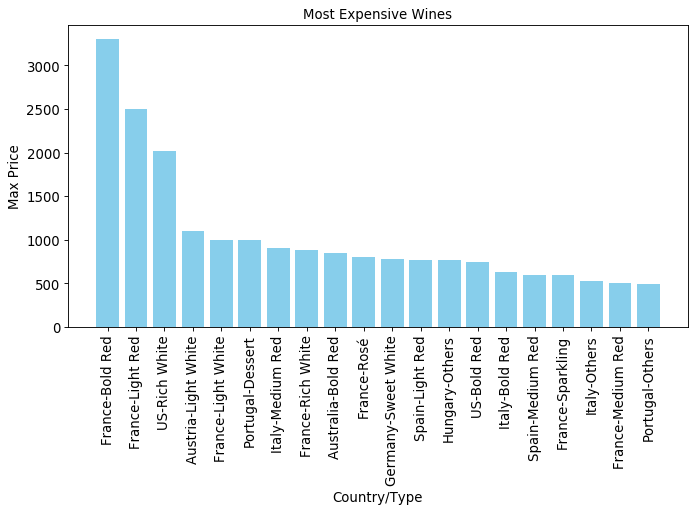

In [316]:
dfcvt=df.pivot_table(index=['vt','country'],values=['price','points'],aggfunc=[np.mean,np.max,np.min])
dfcvt.columns = list(map("_".join, dfcvt.columns))
dfcvt['wine_count']=df.groupby(['vt','country'])['price'].apply(lambda x: x.count())
dfcvt.sort_values(by=['amax_price'],ascending=False,inplace=True)

A=dfcvt.head(20)
B=A[['mean_price','amax_price']]
B.reset_index(inplace=True)

fig, ax= plt.subplots(num=1,figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
l1= ax.bar([x+'-'+y for x,y in zip(B.country,B.vt)], B.amax_price, color='skyblue')
plt.ylim([0,B.amax_price.max()*1.05])
plt.xticks(rotation=90, fontsize=5)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xticks(rotation=90)
plt.xlabel("Country/Type",fontsize=12)
plt.ylabel("Max Price",fontsize=12)
plt.title("Most Expensive Wines")
plt.show()

In [318]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
  "data": [
    {
      "values": [16, 15, 12, 6, 5, 4, 42],
      "labels": Wine_types.keys(),
      "domain": {"x": [0, .48]},
      "name": "Wine Average (Mean) Price by Variety",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },
    {
      "values": [27, 11, 25, 8, 1, 3, 25],
      "labels":  Wine_types.keys(),
      "text":["CO2"],
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Mean Price",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"GLobal Wine Price by Variety",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Mean",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Maximum",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
#py.iplot(fig, filename='donut')

In [319]:
df['vt'].value_counts()

Bold Red       35983
Others         14881
Light Red      14829
Medium Red     13985
Rich White     12512
Light White    12028
Sweet White     5930
Dessert         4068
Sparkling       3439
Rosé            3261
Name: vt, dtype: int64

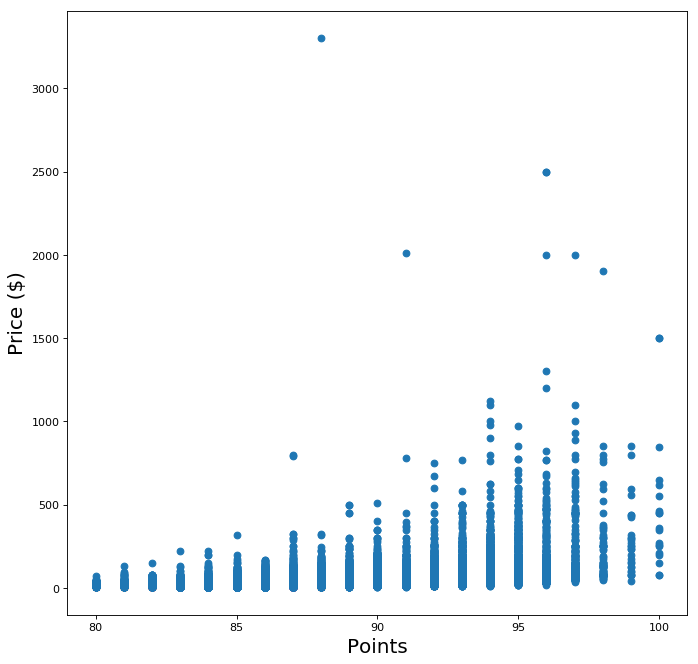

In [320]:
fig,ax=plt.subplots(num=1,figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
l1=ax.scatter(df.points,df.price)
ax.set_xlabel('Points',fontsize=18)
ax.set_ylabel('Price ($)',fontsize=18)
plt.locator_params(axis='x', nbins=5)

In [802]:
#extract points and price columns
df_numeric=df._get_numeric_data()

#making bins in which Data will be held and creating a group based off of the bins
bins = [80,85,90,95,101]

# Create the names for the four bins
group_names = ['80-84','85-89','90-94','95-100']

df_numeric["points_avg"] = pd.cut(df_numeric["points"], bins, labels=group_names, right=False)
df_bins = df_numeric.groupby("points_avg",as_index=False)
print(df_bins.describe())
#plot the categorized data in four bins

    points                                                        price  \
     count       mean       std   min   25%   50%   75%    max    count   
0  11830.0  83.150465  1.083081  80.0  83.0  84.0  84.0   84.0  11830.0   
1  63713.0  87.142436  1.297626  85.0  86.0  87.0  88.0   89.0  63713.0   
2  43162.0  91.387563  1.287237  90.0  90.0  91.0  92.0   94.0  43162.0   
3   2211.0  95.592492  0.969638  95.0  95.0  95.0  96.0  100.0   2211.0   

                                                            
         mean         std   min   25%   50%    75%     max  
0   18.764497   12.061176   4.0  12.0  15.0   22.0   225.0  
1   25.944203   22.319006   4.0  15.0  20.0   30.0  3300.0  
2   48.521593   38.540778   7.0  27.0  40.0   59.0  2013.0  
3  139.022614  172.621707  20.0  60.0  85.0  149.0  2500.0  


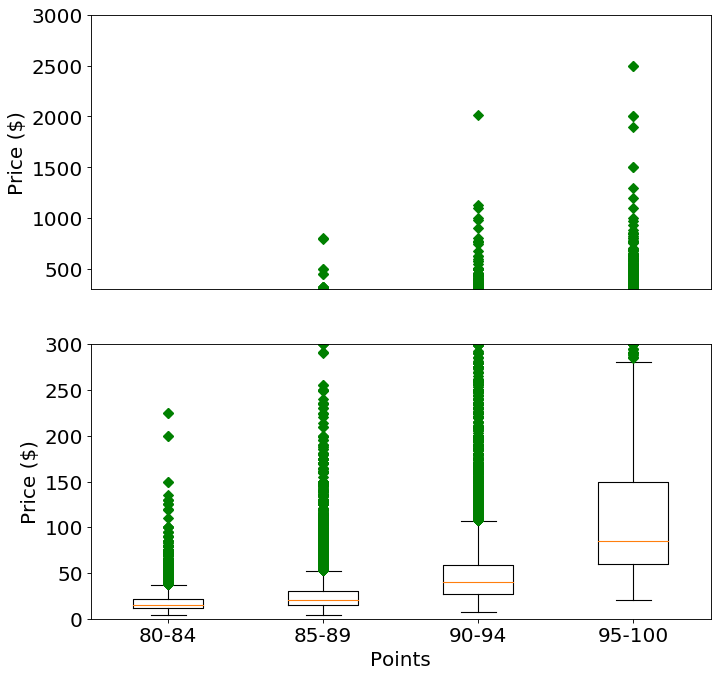

In [824]:
import matplotlib
fignum=20
#plot the categorized data in four bins
matplotlib.rc('ytick',labelsize=18)

tick_labels =list(df_bins.groups.keys())
A=[]
for keys in tick_labels:
    A.append(df_bins.get_group(keys).price)

fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
ax1=fig.add_subplot(2,1,1)   
ax1.boxplot(A,0,'gD')
#ax1.set_xticklabels(tick_labels)
ax1.set_ylabel('Price ($)',fontsize=18)
ax1.set_ylim(300,3000)
ax1.axes.get_xaxis().set_visible(False)
#df_bins.describe()

ax2=fig.add_subplot(2,1,2)  
ax2.boxplot(A,notch=False,sym='gD',vert=True,whis=1.5)
ax2.set_xticklabels(tick_labels,fontsize=18)
ax2.set_xlabel('Points',fontsize=18)
ax2.set_ylabel('Price ($)',fontsize=18)
#ax2.axes.get_xaxis().set_visible(True)
ax2.set_ylim(0,300)

plt.savefig("../reports/images/"+str(fignum)+"-Wine_Price_vs_Ratings.png",bbox_inches="tight")
plt.show()

C:\Users\beygi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

scipy.stats.norm.pdf



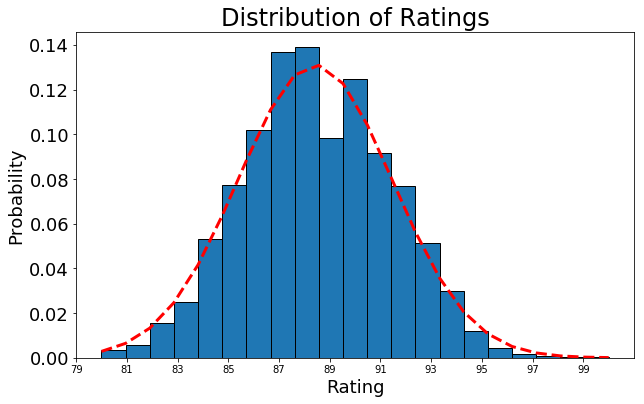

In [839]:
# Plot probability distribution for taster ratings
plt.figure(figsize=(10,6))
num_bins = 21
(mu, sigma) = norm.fit(df.points)
n, bins, patches = plt.hist(df.points, num_bins, density=1, edgecolor='k',histtype='bar')
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=3)
plt.xticks(range(df.points.min()-1,df.points.max()+1,2))
plt.xlabel('Rating',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.title('Distribution of Ratings',fontsize=24)
plt.show()

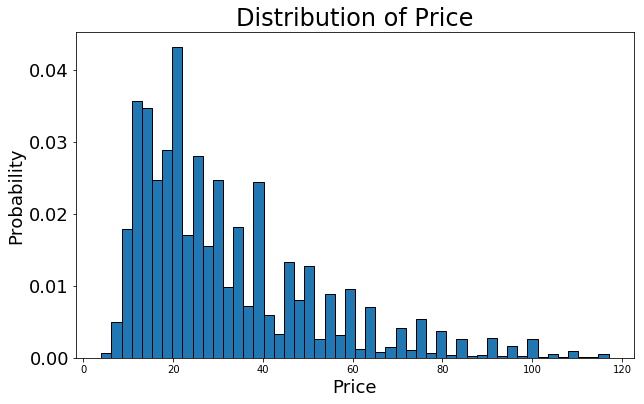

In [858]:
# Plot probability distribution for wine price ratings
plt.figure(figsize=(10,6))
num_bins = 50
(mu, sigma) = norm.fit(df.price)
A=df.price[(df.price>mu-2*sigma) & (df.price<mu+2*sigma)]
n, bins, patches = plt.hist(A, num_bins, density=1, edgecolor='k',histtype='bar')
plt.xlabel('Price',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.title('Distribution of Price',fontsize=24)
plt.show()

!! Multiple means

In [323]:
# In order to plot the avg price, avg points, and count of each wine globally, we started to work with
# province/country combination for all the countries globally. But, when plotted the heatmap, the circles
# from small provinces (for example in Portegaul) were intereferring and that we could not observe the results as expected.
# Then, we decided to divide the data into two group:
# 1) All the wines from every region in the owrld except for the US was represented by the country.
# 2) The US wines were represented by each state.
# In the following, first we work with the countries followed by the state/US section

dfc=df.pivot_table(index='country',values=['price','points'],aggfunc=[np.mean,np.max,np.min])
dfc.columns = list(map("_".join, dfc.columns))
dfc['wine_count']=df.groupby(['country'])['price'].apply(lambda x: x.count())
dfc['name']=dfc.index
dfc['lat']=0
dfc['lng']=0


df_US=df[df.country=='US']
dfUS=df_US.pivot_table(index='province',values=['price','points'],aggfunc=[np.mean,np.max,np.min])
dfUS.columns = list(map("_".join, dfUS.columns))
dfUS['wine_count']=df_US.groupby(['province'])['price'].apply(lambda x: x.count())
dfUS['name']=dfUS.index
dfUS['lat']=0
dfUS['lng']=0
dfUS.sort_values(by=['amax_price'],ascending=False)

,mean_points,mean_price,amax_points,amax_price,amin_points,amin_price,wine_count,name,lat,lng
province,,,,,,,,,,
California,88.629515,39.041048,100,2013.0,80,4.0,36104,California,0,0
Oregon,89.053741,36.545064,99,275.0,80,5.0,5359,Oregon,0,0
Michigan,86.153153,32.432432,91,250.0,82,13.0,111,Michigan,0,0
Washington,88.951416,32.436444,100,240.0,80,6.0,8583,Washington,0,0
New York,87.181241,22.826233,94,125.0,80,7.0,2676,New York,0,0
Colorado,86.117647,32.985294,91,100.0,80,12.0,68,Colorado,0,0
Virginia,85.619481,27.012987,92,100.0,80,10.0,770,Virginia,0,0
Texas,85.215054,25.602151,89,80.0,80,8.0,93,Texas,0,0
America,86.505263,19.894737,94,75.0,80,6.0,95,America,0,0


In [324]:
#find country and US provinces locations
import gmaps
import requests
import json

from api_keys import (owmkey,gkey)
# base paramters
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
params = {
        "address": "",
        "key": gkey
}

ii=0
for x in dfc.index:
    # set up a parameters dictionary
    params['address']= x
    response = requests.get(base_url, params=params)
    
    #print(json.dumps(response, indent=4, sort_keys=True)) 
    if (response.status_code == 200):
        print(x)
        response=response.json()
        if (response['status'] != 'ZERO_RESULTS'):
            ii+=1
            dfc.loc[x,'lat']=response['results'][0]['geometry']['location']['lat']
            dfc.loc[x,'lng']=response['results'][0]['geometry']['location']['lng']
#print('Country location reading completed:\n{} successful read out of {} countries\n'.format(ii,i))

ii=0
for x in dfUS.index:
    # set up a parameters dictionary
    params['address']= x + ', US'
    response = requests.get(base_url, params=params)
    
    #print(json.dumps(response, indent=4, sort_keys=True)) 
    if (response.status_code == 200):
        print(x)
        response=response.json()
        if (response['status'] != 'ZERO_RESULTS'):
            ii+=1
            dfUS.loc[x,'lat']=response['results'][0]['geometry']['location']['lat']
            dfUS.loc[x,'lng']=response['results'][0]['geometry']['location']['lng']
#print('US location reading completed:\n{} successful read out of {} US states\n'.format(ii,i))

Argentina
Armenia
Australia
Austria
Bosnia and Herzegovina
Brazil
Bulgaria
Canada
Chile
China
Croatia
Cyprus
Czech Republic
England
France
Georgia
Germany
Greece
Hungary
India
Israel
Italy
Lebanon
Luxembourg
Macedonia
Mexico
Moldova
Morocco
New Zealand
Peru
Portugal
Romania
Serbia
Slovakia
Slovenia
South Africa
Spain
Switzerland
Turkey
US
Ukraine
Uruguay
America
Arizona
California
Colorado
Connecticut
Hawaii
Idaho
Illinois
Iowa
Kentucky
Massachusetts
Michigan
Missouri
Nevada
New Jersey
New Mexico
New York
North Carolina
Ohio
Oregon
Pennsylvania
Rhode Island
Texas
Vermont
Virginia
Washington
Washington-Oregon


In [793]:
#defining the function to plot gmaps
def gmap_plot(df_plot,par_Plot):
    import gmaps
    #Average price analysis
    #---------------------------- heatmap layer: countries

    #avgprc_symbol: symbol-layer + R-G heatmap of wine avg price

    locations = df_plot[["lat", "lng"]].astype(float)

    # Create a poverty Heatmap layer
    fig = gmaps.figure()

    a=np.reshape(np.array(df_plot[par_Plot]),(-1,1))
    b=[item for sublist in a for item in sublist]#takes 1*1*n array and return 1*n array, e.g. [[1],[2],[3]] to [1,2,3]
    b=[(x-min(b))/(max(b)-min(b))*100 for x in b]
    avgprc_heat = gmaps.heatmap_layer(locations, weights=b,
                                     dissipating=False, max_intensity=100,
                                     point_radius = 2)
    #gmaps.heatmap.gradient = [
    #    'white',
    #    'orange',
    #    'red',
    #    'green',
    #    'blue',
    #    'black'
    #]

    # Adjust avgprc_layer setting to help with heatmap dissipating on zoom
    avgprc_heat.dissipating = False
    avgprc_heat.max_intensity = 100
    avgprc_heat.point_radius = 2


    #---------------------------- symbol layer:countries
    #box tempelate on the gampes with multiple paramters printing on (we also need to convery the dataframe to dictionary)

    df_plot['mean_price_str']=df_plot['mean_price'].map("{:.1f}".format)  #required for multiparam info box
    df_plot['mean_points_str']=df_plot['mean_points'].map("{:.1f}".format)  #required for multiparam info box
    
    info_box_template = """
    <dl>
    <dt>Country/State:</dt><dd>{name}</dd>
    <dt>Avg. Price:</dt><dd>{mean_price_str}</dd>
    <dt>Avg. Points:</dt>{mean_points_str}<dd>
    <dt>Price Range:</dt><dd>[{amin_price}-{amax_price}]</dd>
    <dt>Points Range:</dt>[{amin_points}-{amax_points}]<dd>
    <dt>Wine Count:</dt><dd>{wine_count}</dd>
    </dl>
    """
    
    dfc_dict=df_plot.to_dict('records') #required for multiparam info box
    box_info = [info_box_template.format(**x) for x in dfc_dict]
    
    avgprc_symbol = gmaps.symbol_layer(
        locations, fill_color='rgba(0, 150, 0, 0.1)',
        stroke_color='rgba(0, 0, 150, 0.1)', scale=1,
        info_box_content=box_info
    )

    avgprc_symbol.dissipating = True
    avgprc_symbol.max_intensity = 100
    avgprc_symbol.point_radius = 3
    #--------------------------- Plot all layers on top of each other
#    fig.add_layer(avgprc_symbol)
#    fig.add_layer(avgprc_heat)
#    return fig

    return avgprc_heat,avgprc_symbol

In [794]:
# plot max price
fig = gmaps.figure(center=(14.09,-76.91),zoom_level=3)

a, b=gmap_plot(dfc,'amax_price')
c, d=gmap_plot(dfUS,'amax_price')
fig.add_layer(a)
fig.add_layer(b)
fig.add_layer(c)
fig.add_layer(d)
fig

Figure(layout=FigureLayout(height='420px'))

In [795]:
# plot mean price
gmaps.configure(api_key=gkey)
fig = gmaps.figure(center=(14.09,-76.91),zoom_level=3)

a, b=gmap_plot(dfc,'mean_price')
c, d=gmap_plot(dfUS,'mean_price')
fig.add_layer(a)
fig.add_layer(b)
fig.add_layer(c)
fig.add_layer(d)

fig

Figure(layout=FigureLayout(height='420px'))

In [797]:
# plot mean ratings
fig = gmaps.figure(center=(14.09,-76.91),zoom_level=3)

a, b=gmap_plot(dfc,'mean_points')
c, d=gmap_plot(dfUS,'mean_points')
fig.add_layer(a)
fig.add_layer(b)
fig.add_layer(c)
fig.add_layer(d)

fig

Figure(layout=FigureLayout(height='420px'))

In [329]:
#import seaborn as sns
#sns.distplot( dfv["count"] , color="skyblue", label="Sepal Length")
#sns.distplot( dfv["price"] , color="red", label="Sepal Width")

## Exploring and visualizing the 130k data and Giant MS-Excel files

First, in order to plot the results in gmaps widgets, we need to vectroize the consumption of each country

In [331]:
def findlatlng(x):
    # set up a parameters dictionary
    params['address']= x
    response = requests.get(base_url, params=params)
    
    #print(json.dumps(response, indent=4, sort_keys=True)) 
    if (response.status_code == 200):
        #print(x)
        response=response.json()
        if (response['status'] != 'ZERO_RESULTS'):
            lati=response['results'][0]['geometry']['location']['lat']
            lngi=response['results'][0]['geometry']['location']['lng']
        else: 
            lati= np.nan
            lngi=np.nan
            
    return lati,lngi

Vectorizing a dataframe as an imput to the interactive Jupypter widget  (from giant file)

In [690]:
def vector_togmaps(df):
    vector_out=pd.DataFrame([])
    df_=df.replace(-1,1E-6)
    vecsize=df_.shape[0]*(df_.shape[1])
    vector_out['country']=np.resize(df_.T.index,(df_.shape[0]*(df_.shape[1]),1)).tolist()

    a_lat = []
    a_lng = []
    for con in df.columns:
        a_lat.append(findlatlng(con)[0])
        a_lng.append(findlatlng(con)[1])

    vector_out['lat'] =np.resize(a_lat,vecsize).tolist()
    vector_out['lng'] =np.resize(a_lng,vecsize).tolist()
    #XXX : wine consumption
    vector_out['XXX']=np.resize(df_,vecsize).tolist()
    vector_out=vector_out.dropna(how='any')
    vector_out=vector_out.reset_index(drop=True)

    A=np.asarray(df_.index.tolist())
    #vector_out['year']=np.repeat(A, vector_out.shape[0]/len(A)).tolist()
    vector_out['year']=np.repeat(A, vector_out.shape[0]/len(A)).tolist()

    #keep only >0 elements
    #condition=vector_out.XXX>0
    #vector_out.where(cond=condition,inplace=True)
    #vector_out=vector_out.dropna(how='any')

    condition=vector_out.country !='World'
    vector_out.where(cond=condition,inplace=True)
    vector_out=vector_out.dropna(how='any')

    vector_out.year=vector_out.year.astype(int)
    return vector_out
#vector_out.to_excel("annual_wine_consumption_dataframe.xlsx")

Jupyter widget for exploring the consumption sheet of the giant wine Excel file dataset.
The user uses the slider to choose a year. This renders the annual global wine consumption heatmap in that year.

In [749]:
# Jupyter widget
from IPython.display import display
import ipywidgets as widgets

class Consumption(object):


    def __init__(self, df):
        self._df = df
        self._heatmap = None
        self._slider = None
        initial_year = min(self._df['year'])

        title_widget = widgets.HTML(
            '<h3>Annual Global Wine Consumption</h3>'
            '<h4>Data from <a href="https://www.adelaide.edu.au/wine-econ/databases">Wine Project</a></h4>'
        )

        map_figure = self._render_map(initial_year)
        controls = self._render_controls(initial_year)
        self._container = widgets.VBox([title_widget, controls, map_figure])

    def render(self):
        display(self._container)

    def _on_year_change(self, change):
        year = self._slider.value
        self._heatmap.locations = self._locations_for_year(year)
        self._total_box.value = self._total_consumption_text_for_year(year)
        return self._container

    def _render_map(self, initial_year):
        fig = gmaps.figure(center=(14.09,-76.91),zoom_level=2)
        self._heatmap = gmaps.heatmap_layer(
            self._locations_for_year(initial_year),
            self._annual_consumption_for_year(initial_year),
            max_intensity=100,
            dissipating=False,
            point_radius=4,
        )
        '''
        self._heatmap.gradient = [
          'rgba(0, 255, 255, 0)',
          'rgba(0, 255, 255, 1)',
          'rgba(0, 191, 255, 1)',
          'rgba(0, 127, 255, 1)',
          'rgba(0, 63, 255, 1)',
          'rgba(0, 0, 255, 1)',
          'rgba(0, 0, 223, 1)',
          'rgba(0, 0, 191, 1)',
          'rgba(0, 0, 159, 1)',
          'rgba(0, 0, 127, 1)',
          'rgba(63, 0, 91, 1)',
          'rgba(127, 0, 63, 1)',
          'rgba(191, 0, 31, 1)',
          'rgba(255, 0, 0, 1)'
        ]
        '''
        #self._heatmap.set('gradient', heatmap.get('gradient') ? null : gradient);

        fig.add_layer(self._heatmap)
        return fig

        
    def _render_controls(self, initial_year):
        self._slider = widgets.IntSlider(
            value=initial_year,
            min=min(self._df['year']),
            max=max(self._df['year']),
            description='Year',
            continuous_update=False
        )
        self._total_box = widgets.Label(
            value=self._total_consumption_text_for_year(initial_year)
        )
        self._slider.observe(self._on_year_change, names='value')
        controls = widgets.HBox(
            [self._slider, self._total_box],
            layout={'justify_content': 'space-between'}
        )
        return controls

    def _locations_for_year(self, year):
        return self._df[self._df['year'] == year][['lat', 'lng']]

    def _total_consumption_for_year(self, year):
        return int(self._df[self._df['year']==year]['XXX'].sum()/1000000)
    
    # I ADDED for weights of heatmap
    def _annual_consumption_for_year(self, year):
        #return (self._df[self._df['year']==year]['XXX'])
        return (self._df[self._df['year']==year]['XXX']-self._df['XXX'].min())/(self._df['XXX'].max()-self._df['XXX'].min())*1000


    def _total_consumption_text_for_year(self, year):
        #print('year=',year)
        return 'Global Wine Consumption: {} (BL)'.format(self._total_consumption_for_year(year))

This function simply plots a heatmap for a par_plot column of a df_plot dataframe for a selected year

In [342]:
def heatmap_plot(df_plot,par_plot,yr):
    #Average price analysis
    #---------------------------- heatmap layer: countries

    #avgprc_symbol: symbol-layer + R-G heatmap of wine avg price
    A=df_plot[df_plot.year==yr]
    locations = A[["lat", "lng"]].astype(float)

    # Create a poverty Heatmap layer
    fig = gmaps.figure()

    a=np.reshape(np.array(A[par_plot]),(-1,1))
    b=[item for sublist in a for item in sublist]#takes 1*1*n array and return 1*n array, e.g. [[1],[2],[3]] to [1,2,3]

    hm = gmaps.heatmap_layer(locations, weights=A[par_plot],
                                     dissipating=False, max_intensity=100,
                                     point_radius = 6)
    
    # hm.gradient = ['white','red']
    return hm

In [716]:
#global wine production volume (vectorized) excluding world as a country
dfwpv_vector=vector_togmaps(dfwpv)
dfwpv_vector.country=[dfwpv_vector.country[x][0] for x in dfwpv_vector.index]
dfwpv_vector.drop( dfwpv_vector[ dfwpv_vector.country == 'World'].index , inplace=True)
#dfwpv_vector.XXX=np.log(dfwpv_vector.XXX)
#dfwpv_vector.XXX=[int(round(x)) for x in dfwpv_vector.XXX]

In [691]:
#global wine consumption volume (vectorized) excluding world as a country
dfwcv_vector=vector_togmaps(dfwcv)
dfwcv_vector.country=[dfwcv_vector.country[x][0] for x in dfwcv_vector.index]
dfwcv_vector.drop( dfwcv_vector[ dfwcv_vector.country == 'World'].index , inplace=True)
#dfwcv_vector.country=[dfwcv_vector.country[x][0] for x in dfwcv_vector.index]
#dfwcv_vector.drop( dfwcv_vector[ dfwcv_vector.country == 'World'].index , inplace=True)
#dfwcv_vector.XXX=np.log(dfwcv_vector.XXX)

In [661]:
'China' in (dfwcv_vector.country[x][0] for x in range(len(dfwcv_vector.country)))

True

In [705]:
#global wine consumption per capita (vectorized) excluding world as a country
dfwcpc_vector=vector_togmaps(dfwcpc)
dfwcpc_vector.country=[dfwcpc_vector.country[x][0] for x in dfwcpc_vector.index]
dfwcpc_vector.drop( dfwcpc_vector[ dfwcpc_vector.country == 'World'].index , inplace=True)
#dfwcpc_vector.XXX=np.log(dfwcpc_vector.XXX)

plotting interactive global wine consumption in 1865-2016

In [754]:
gmaps.configure(api_key=gkey)
B=dfwcv_vector.copy()
#.XXX=(B.XXX-B.XXX.min())/(B.XXX.max()-B.XXX.min())*1000
B=B[['year','lat','lng','XXX']]
Consumption(B).render()

Now we plot the time history of production volume/consumption volume (generating 3 gmap heatmaps per parameter)
Note: it is required so that we keep the colorbar of time-series for each parameter consistent

In [718]:
#plotting world production volume for the selected list of years
yr=[1900,1950,2014]
A=dfwpv_vector[dfwpv_vector.year==yr[0]]
B=dfwpv_vector[dfwpv_vector.year==yr[1]]
C=dfwpv_vector[dfwpv_vector.year==yr[2]]

B=B.merge(A, left_on='country', right_on='country')
B=B.merge(C, left_on='country', right_on='country')
B_min=min(B['XXX'].min(),B['XXX_x'].min(),B['XXX_y'].min())
B_max=max(B['XXX'].max(),B['XXX_x'].max(),B['XXX_y'].max())
B['XXX_norm_yr2']=(B['XXX']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr1']=(B['XXX_x']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr0']=(B['XXX_y']-B_min)/(B_max-B_min)*100

In [727]:
fig = gmaps.figure(center=(14,0),zoom_level=2)

# Create heat layer
heat_layer = gmaps.heatmap_layer(B[["lat_x", "lng_x"]].astype(float), weights=B.XXX_norm_yr2, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=4)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [696]:
#plotting world consumption volume for the selected list of years
import math
A=dfwcv_vector[dfwcv_vector.year==yr[0]]
B=dfwcv_vector[dfwcv_vector.year==yr[1]]
C=dfwcv_vector[dfwcv_vector.year==yr[2]]

B=B.merge(A, left_on='country', right_on='country')
B=B.merge(C, left_on='country', right_on='country')
#B_min=np.log(min(B['XXX'].min(),B['XXX_x'].min(),B['XXX_y'].min()))
#B_max=np.log(max(B['XXX'].max(),B['XXX_x'].max(),B['XXX_y'].max()))
#B['XXX_norm_yr2']=(np.log(B['XXX'])-B_min)/(B_max-B_min)*100
#B['XXX_norm_yr1']=(np.log(B['XXX_x'])-B_min)/(B_max-B_min)*100
#B['XXX_norm_yr0']=(np.log(B['XXX_y'])-B_min)/(B_max-B_min)*100
B_min=min(B['XXX'].min(),B['XXX_x'].min(),B['XXX_y'].min())
B_max=max(B['XXX'].max(),B['XXX_x'].max(),B['XXX_y'].max())
B['XXX_norm_yr2']=(B['XXX']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr1']=(B['XXX_x']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr0']=(B['XXX_y']-B_min)/(B_max-B_min)*100
B

,country,lat_x,lng_x,XXX_x,year_x,lat_y,lng_y,XXX_y,year_y,lat,lng,XXX,year,XXX_norm_yr2,XXX_norm_yr1,XXX_norm_yr0
0,France,46.227638,2.213749,5.384300e+06,1950,46.227638,2.213749,5.361643e+06,1900,46.227638,2.213749,2.786903e+06,2014,51.759794,1.000000e+02,9.957921e+01
1,Italy,41.871940,12.567380,4.051908e+06,1950,41.871940,12.567380,3.100880e+06,1900,41.871940,12.567380,1.950000e+06,2014,36.216407,7.525412e+01,5.759114e+01
2,Portugal,39.399872,-8.224454,6.961000e+05,1950,39.399872,-8.224454,3.838094e+05,1900,39.399872,-8.224454,4.453508e+05,2014,8.271285,1.292833e+01,7.128306e+00
3,Spain,40.463667,-3.749220,1.143822e+06,1950,40.463667,-3.749220,1.745061e+06,1900,40.463667,-3.749220,7.000000e+05,2014,13.000761,2.124366e+01,3.241017e+01
4,Austria,47.516231,14.550072,1.022667e+05,1950,47.516231,14.550072,2.501379e+05,1900,47.516231,14.550072,2.467157e+05,2014,4.582131,1.899349e+00,4.645691e+00
5,Norway,60.472024,8.468946,1.000000e-06,1950,60.472024,8.468946,1.000000e-06,1900,60.472024,8.468946,9.632310e+04,2014,1.788962,1.857252e-11,1.857252e-11
6,Belgium,50.503887,4.469936,5.187150e+04,1950,50.503887,4.469936,2.590000e+04,1900,50.503887,4.469936,3.705801e+05,2014,6.882605,9.633843e-01,4.810282e-01
7,Denmark,56.263920,9.501785,5.800000e+03,1950,56.263920,9.501785,4.400000e+03,1900,56.263920,9.501785,1.697624e+05,2014,3.152915,1.077206e-01,8.171907e-02
8,Finland,61.924110,25.748151,2.004450e+03,1950,61.924110,25.748151,1.000000e-06,1900,61.924110,25.748151,6.381063e+04,2014,1.185124,3.722768e-02,1.857252e-11
9,Germany,51.165691,10.451526,3.091750e+05,1950,51.165691,10.451526,1.657520e+05,1900,51.165691,10.451526,1.812997e+06,2014,33.671920,5.742158e+00,3.078432e+00


In [700]:
fig = gmaps.figure(center=(14,0),zoom_level=2)

# Create heat layer
heat_layer = gmaps.heatmap_layer(B[["lat_x", "lng_x"]].astype(float), weights=B.XXX_norm_yr0, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=4)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [706]:
#plotting world consumption per capita for the selected list of years
import math
A=dfwcpc_vector[dfwcpc_vector.year==yr[0]]
B=dfwcpc_vector[dfwcpc_vector.year==yr[1]]
C=dfwcpc_vector[dfwcpc_vector.year==yr[2]]

B=B.merge(A, left_on='country', right_on='country')
B=B.merge(C, left_on='country', right_on='country')
#B_min=np.log(min(B['XXX'].min(),B['XXX_x'].min(),B['XXX_y'].min()))
#B_max=np.log(max(B['XXX'].max(),B['XXX_x'].max(),B['XXX_y'].max()))
#B['XXX_norm_yr2']=(np.log(B['XXX'])-B_min)/(B_max-B_min)*100
#B['XXX_norm_yr1']=(np.log(B['XXX_x'])-B_min)/(B_max-B_min)*100
#B['XXX_norm_yr0']=(np.log(B['XXX_y'])-B_min)/(B_max-B_min)*100
B_min=min(B['XXX'].min(),B['XXX_x'].min(),B['XXX_y'].min())
B_max=max(B['XXX'].max(),B['XXX_x'].max(),B['XXX_y'].max())
B['XXX_norm_yr2']=(B['XXX']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr1']=(B['XXX_x']-B_min)/(B_max-B_min)*100
B['XXX_norm_yr0']=(B['XXX_y']-B_min)/(B_max-B_min)*100
B

,country,lat_x,lng_x,XXX_x,year_x,lat_y,lng_y,XXX_y,year_y,lat,lng,XXX,year,XXX_norm_yr2,XXX_norm_yr1,XXX_norm_yr0
0,France,46.227638,2.213749,126.635778,1950,46.227638,2.213749,132.066684,1900,46.227638,2.213749,41.792046,2014,31.644655,9.588775e+01,1.000000e+02
1,Italy,41.871940,12.567380,86.368839,1950,41.871940,12.567380,92.274360,1900,41.871940,12.567380,31.600441,2014,23.927640,6.539790e+01,6.986952e+01
2,Portugal,39.399872,-8.224454,82.449439,1950,39.399872,-8.224454,71.023196,1900,39.399872,-8.224454,42.812548,2014,32.417372,6.243016e+01,5.377828e+01
3,Spain,40.463667,-3.749220,40.759149,1950,40.463667,-3.749220,93.992299,1900,40.463667,-3.749220,15.131956,2014,11.457815,3.086255e+01,7.117033e+01
4,Austria,47.516231,14.550072,14.746243,1950,47.516231,14.550072,41.878107,1900,47.516231,14.550072,28.967723,2014,21.934164,1.116576e+01,3.170982e+01
5,Norway,60.472024,8.468946,0.000001,1950,60.472024,8.468946,0.000001,1900,60.472024,8.468946,18.750000,2014,14.197373,7.571932e-07,7.571932e-07
6,Belgium,50.503887,4.469936,5.805457,1950,50.503887,4.469936,3.854740,1900,50.503887,4.469936,31.449542,2014,23.813381,4.395853e+00,2.918783e+00
7,Denmark,56.263920,9.501785,1.357996,1950,56.263920,9.501785,1.718079,1900,56.263920,9.501785,30.062945,2014,22.763458,1.028265e+00,1.300918e+00
8,Finland,61.924110,25.748151,0.500000,1950,61.924110,25.748151,0.000001,1900,61.924110,25.748151,11.644998,2014,8.817514,3.785966e-01,7.571932e-07
9,Germany,51.165691,10.451526,4.458440,1950,51.165691,10.451526,3.047585,1900,51.165691,10.451526,22.328102,2014,16.906688,3.375901e+00,2.307610e+00


In [711]:
fig = gmaps.figure(center=(14,0),zoom_level=2)

# Create heat layer
heat_layer = gmaps.heatmap_layer(B[["lat_x", "lng_x"]].astype(float), weights=B.XXX_norm_yr2, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=4)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))